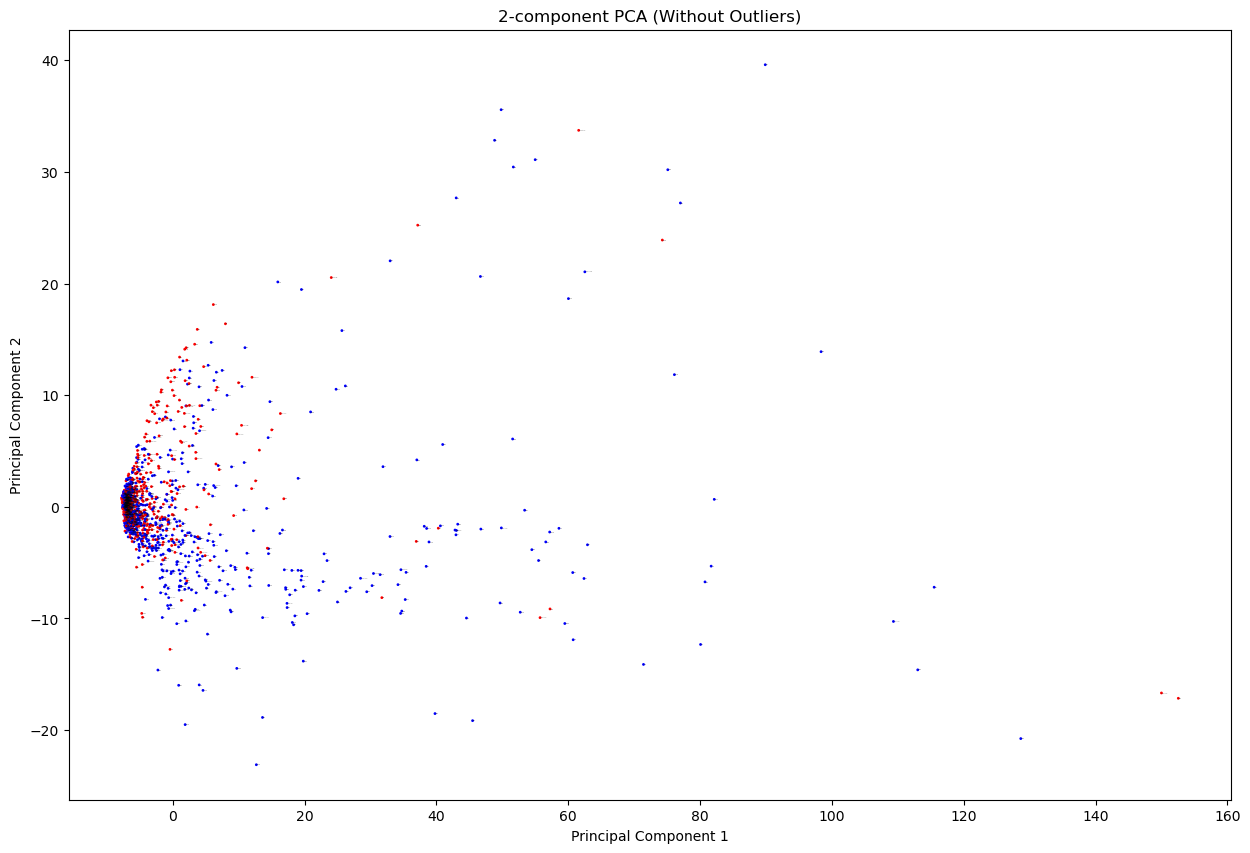

Scatter data saved as scatter_data.csv.


In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv('alldata_without_outlier.csv')

# Extract the features
features = data.iloc[:, 3:]

# Standardize the features
features_standardized = features  # Consider standardizing the features for PCA for better results.

# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(features_standardized)

# Convert the results to a DataFrame
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Concatenate the ID, SMILES, PC1 and PC2 to form the final DataFrame
scatter_data_df = pd.concat([data['ID'], data['SMILES'], data['label'] ,principal_df], axis=1)

# Save the scatter data as a CSV
scatter_data_df.to_csv('scatter_data.csv', index=False)

# Plotting with a larger figure size
fig, ax = plt.subplots(figsize=(15, 10))  # Setting the figure size to 15x10 inches
colors = {0: 'blue', 1: 'red'}
ax.scatter(final_df['PC1'], final_df['PC2'], c=final_df['label'].map(colors), s=1)

# Labeling dots using their IDs
for i, txt in enumerate(final_df['ID']):
    ax.annotate(txt, (final_df['PC1'].iloc[i], final_df['PC2'].iloc[i]), fontsize=0.8, alpha=0.7)

# Add labels for axes
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('2-component PCA (Without Outliers)')

# Save the figure as a PDF
plt.savefig("large_figurenew.pdf", format='pdf', bbox_inches='tight')  # bbox_inches='tight' ensures the saved figure does not cut off any labels or annotations

# Show the plot
plt.show()

print("Scatter data saved as scatter_data.csv.")


In [3]:
scatter_data_df

,ID,SMILES,label,PC1,PC2
0,J73,Nc1ccc(OCCCOc2ccc(N)cc2N)c(N)c1,1,-0.763558,-1.224736
1,J1261,Cc1ccc2[nH]c3cc4c(=O)c5cc(C)ccc5[nH]c4cc3c(=O)...,0,-0.799233,-8.840484
2,J868,CCCCOC(=O)c1ccccc1N=Nc1c(O)c(C(=O)Nc2ccc3[nH]c...,0,17.127573,-7.388338
3,J672,CC(=O)CC(C)=O,0,-7.366837,0.098708
4,J1223,COc1cc2c(cc1OC)C(C)(C)C(=Cc1ccccc1)C2=O,0,-2.487991,-3.913955
...,...,...,...,...,...
1413,J213,Cc1ccc(C(=O)CC(=O)C(F)(F)F)cc1,1,-4.996657,-0.464213
1414,A146A944,CC(C)C1=CC2=CCC3C(C)(CCCC34C(=O)OCC35CC4(C3)C5...,0,-0.640678,-8.135438
1415,J1245,CC(CC(=O)Oc1ccc(S(=O)(=O)O)cc1)CC(C)(C)C,1,-1.666434,-0.898601
1416,J562,Cc1ccc(S(=O)(=O)Cl)cc1,1,-6.843604,-0.614907


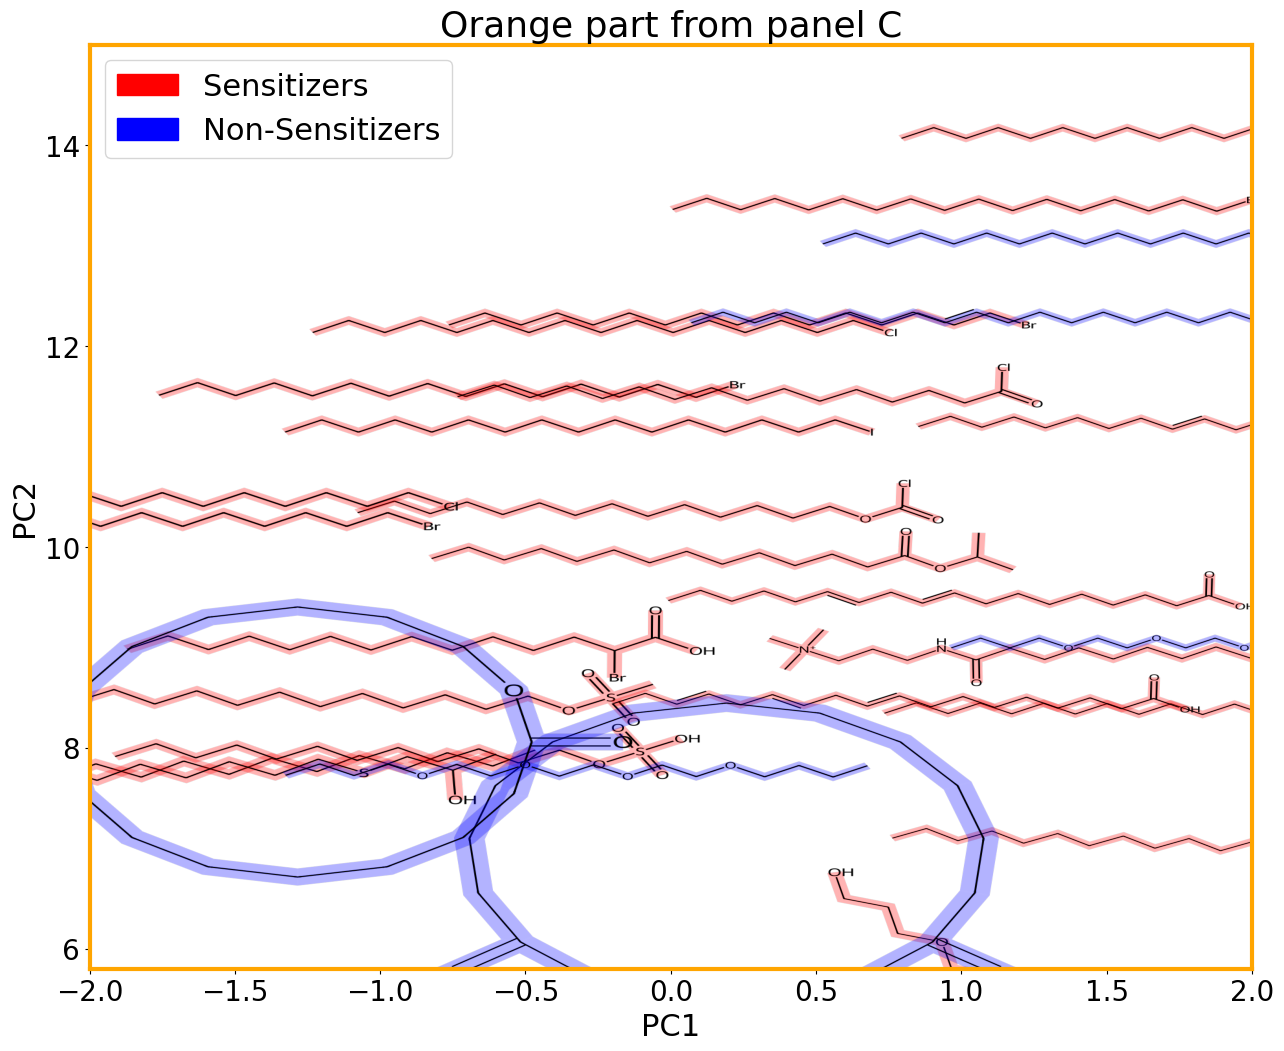

In [4]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
import matplotlib.pyplot as plt
from PIL import Image
import io
xlow=-2
xhigh=2
ylow=5.8
yhigh=15

# Assuming scatter_data_df is the DataFrame with 'ID', 'SMILES', 'PC1', and 'PC2' columns
filtered_df = scatter_data_df[(scatter_data_df['PC1'] > xlow) & (scatter_data_df['PC1'] < xhigh) &
                              (scatter_data_df['PC2'] > ylow) & (scatter_data_df['PC2'] < yhigh)]

# Using filtered scatter_data_df for red_group and blue_group
red_group = [(smiles, (pc1, pc2)) for smiles, pc1, pc2 in filtered_df[filtered_df['label'] == 1][['SMILES', 'PC1', 'PC2']].values]
blue_group = [(smiles, (pc1, pc2)) for smiles, pc1, pc2 in filtered_df[filtered_df['label'] == 0][['SMILES', 'PC1', 'PC2']].values]

def mol_to_image(mol, color, alpha=0.3):
    num_atoms = mol.GetNumAtoms()
    
    # Increase the base size for the image
    size = 50 + num_atoms * 50
    drawer = rdMolDraw2D.MolDraw2DCairo(size, size)
    
    # Set drawing options
    draw_opts = drawer.drawOptions()
    draw_opts.clearBackground = False
    draw_opts.useBWAtomPalette()
    draw_opts.bondLineWidth = 3.0  # Increased bond line width
    draw_opts.atomLabelFontSize = 16  # Adjust this for atom label size if required
    draw_opts.dotsPerAngstrom = 80  # Increase this to get more dots per angstrom, making atoms appear larger
    
    # Color the molecule's bonds with transparency
    transparent_color = (color[0], color[1], color[2], alpha)
    
    bond_colors = {}
    for bond in mol.GetBonds():
        bond_colors[bond.GetIdx()] = transparent_color
    
    # Draw molecule with only bonds highlighted
    drawer.DrawMolecule(mol, highlightAtoms=[], highlightBonds=range(mol.GetNumBonds()), highlightBondColors=bond_colors)
    drawer.FinishDrawing()
    
    # Convert to image and return
    image_data = drawer.GetDrawingText()
    return Image.open(io.BytesIO(image_data))


# Create a scatter plot
fig, ax = plt.subplots(figsize=(15, 12)) 
from rdkit.Chem import Descriptors

def compute_extent(x, y, mol_weight):
    base_extent = 1.8
    # Adjusting factor based on the molecular weight. You can tune this value.
    # The division by 100 is to reduce the weight value to a reasonable factor.
    # Depending on your dataset, you might need to adjust this divisor.
    factor = 0.02 * mol_weight / 100  
    extent_val = base_extent + factor
    return (x - 0.6*extent_val, x + 0.6*extent_val, y - extent_val, y + extent_val)

# Plot molecules from the red group with less transparency
for smiles, (x, y) in red_group:
    mol = Chem.MolFromSmiles(smiles)
    mol_weight = Descriptors.MolWt(mol)
    img = mol_to_image(mol, (1, 0, 0))
    ax.imshow(img, aspect='auto', extent=compute_extent(x, y, mol_weight), alpha=1)

# Plot molecules from the blue group with less transparency
for smiles, (x, y) in blue_group:
    mol = Chem.MolFromSmiles(smiles)
    mol_weight = Descriptors.MolWt(mol)
    img = mol_to_image(mol, (0, 0, 1))
    ax.imshow(img, aspect='auto', extent=compute_extent(x, y, mol_weight), alpha=1)


    
# Set axis limits and display the scatter plot
ax.set_xlim(xlow,xhigh)
ax.set_ylim(ylow, yhigh)
# Set the spine colors to orange
ax.spines['bottom'].set_color('orange')
ax.spines['left'].set_color('orange')
ax.spines['top'].set_color('orange')  # Set top boundary color to orange
ax.spines['right'].set_color('orange')  # Set right boundary color to orange
for spine in ax.spines.values():
    spine.set_linewidth(3)
#ax.xaxis.label.set_color('orange')
#ax.yaxis.label.set_color('orange')
#ax.tick_params(axis='x', colors='orange')
#ax.tick_params(axis='y', colors='orange')
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='red', edgecolor='red', label='Sensitizers'),
                   Patch(facecolor='blue', edgecolor='blue', label='Non-Sensitizers')]

# Adding the legend to the plot with a larger font size
ax.legend(handles=legend_elements, loc='upper left', fontsize=22)
#ax.set_xlabel('X-axis Title', color='orange')  # Replace 'X-axis Title' with your desired title
#ax.set_ylabel('Y-axis Title', color='orange')  # Replace 'Y-axis Title' with your desired title
ax.set_xlabel('PC1', fontsize=22)
ax.set_ylabel('PC2', fontsize=22)
ax.set_title('Orange part from panel C', fontsize=26)
# Adjust the tick label font size
ax.tick_params(axis='both', which='major', labelsize=20)
plt.savefig("orange.pdf", format='pdf', bbox_inches='tight')  # bbox_inches='tight' ensures the saved figure does not cut off any labels or annotations

plt.show()



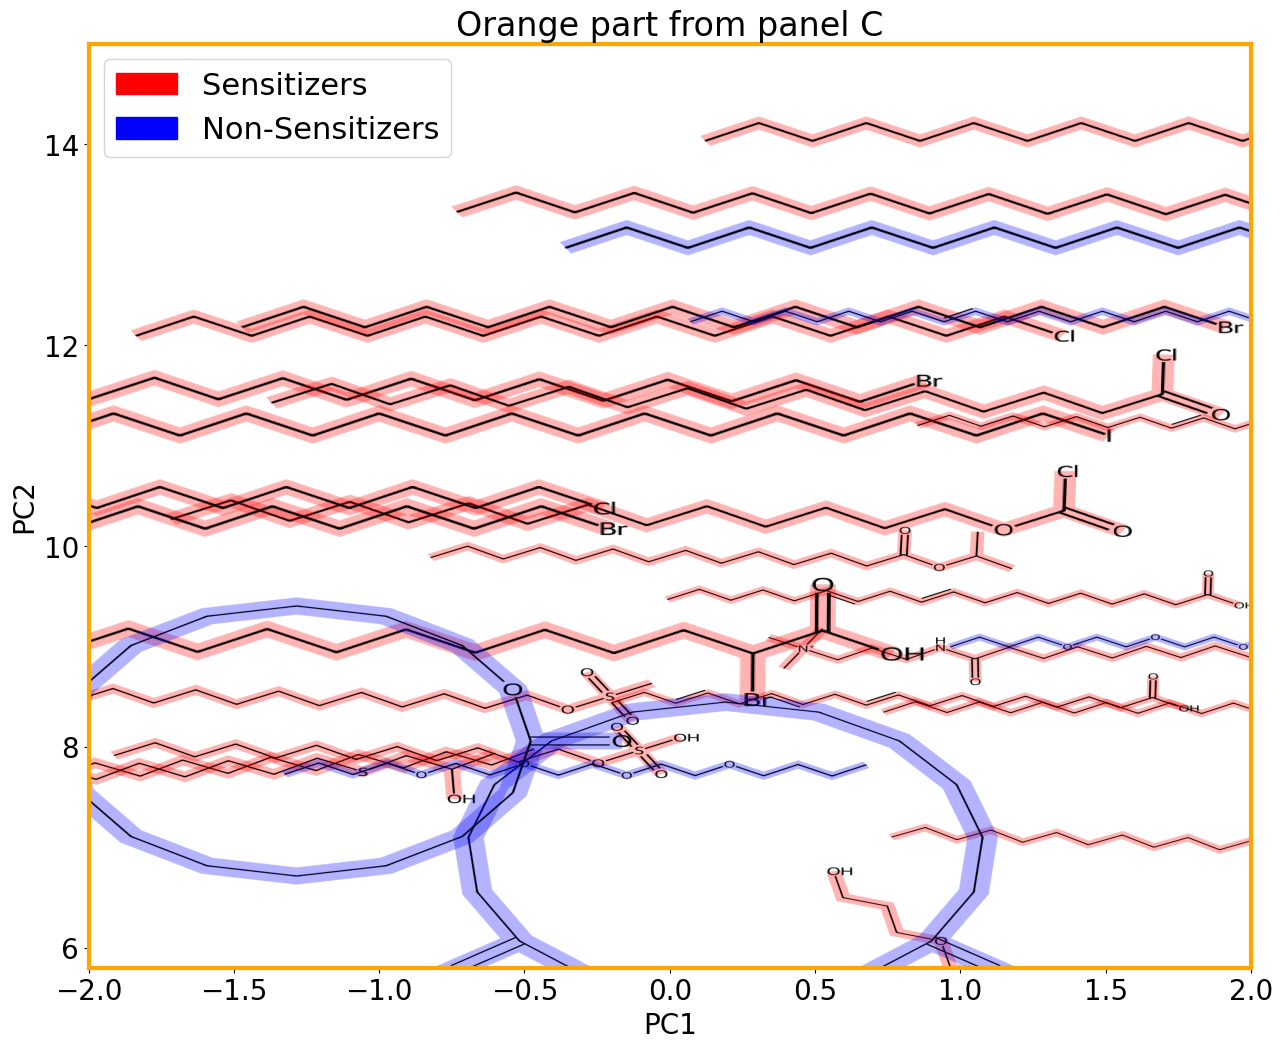

In [5]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
import matplotlib.pyplot as plt
from PIL import Image
import io

xlow=-2
xhigh=2
ylow=5.8
yhigh=15

# Define helper function to check for specific atoms
def has_specific_atoms(mol, atoms=['Br', 'Cl', 'I']):
    return any(atom.GetSymbol() in atoms for atom in mol.GetAtoms())

def compute_extent(x, y, mol_weight, mol):
    base_extent = 1.8
    factor = 0.02 * mol_weight / 100  
    
    # Check if the molecule has Br, Cl, or I
    if has_specific_atoms(mol):
        factor *= 22.5  # Adjust this multiplier as necessary

    extent_val = base_extent + factor
    return (x - 0.6*extent_val, x + 0.6*extent_val, y - extent_val, y + extent_val)

def mol_to_image(mol, color, alpha=0.3):
    num_atoms = mol.GetNumAtoms()
    size = 50 + num_atoms * 50
    drawer = rdMolDraw2D.MolDraw2DCairo(size, size)
    
    draw_opts = drawer.drawOptions()
    draw_opts.clearBackground = False
    draw_opts.useBWAtomPalette()
    draw_opts.bondLineWidth = 3.0
    draw_opts.atomLabelFontSize = 16
    draw_opts.dotsPerAngstrom = 80
    
    transparent_color = (color[0], color[1], color[2], alpha)
    bond_colors = {}
    for bond in mol.GetBonds():
        bond_colors[bond.GetIdx()] = transparent_color
    
    drawer.DrawMolecule(mol, highlightAtoms=[], highlightBonds=range(mol.GetNumBonds()), highlightBondColors=bond_colors)
    drawer.FinishDrawing()
    
    image_data = drawer.GetDrawingText()
    return Image.open(io.BytesIO(image_data))

# Create scatter plot
fig, ax = plt.subplots(figsize=(15, 12)) 
from rdkit.Chem import Descriptors

# Plot molecules from the red group
for smiles, (x, y) in red_group:
    mol = Chem.MolFromSmiles(smiles)
    mol_weight = Descriptors.MolWt(mol)
    img = mol_to_image(mol, (1, 0, 0))
    ax.imshow(img, aspect='auto', extent=compute_extent(x, y, mol_weight, mol), alpha=1)

# Plot molecules from the blue group
for smiles, (x, y) in blue_group:
    mol = Chem.MolFromSmiles(smiles)
    mol_weight = Descriptors.MolWt(mol)
    img = mol_to_image(mol, (0, 0, 1))
    ax.imshow(img, aspect='auto', extent=compute_extent(x, y, mol_weight, mol), alpha=1)

ax.set_xlim(xlow,xhigh)
ax.set_ylim(ylow, yhigh)
ax.spines['bottom'].set_color('orange')
ax.spines['left'].set_color('orange')
ax.spines['top'].set_color('orange')
ax.spines['right'].set_color('orange')
for spine in ax.spines.values():
    spine.set_linewidth(3)

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='red', edgecolor='red', label='Sensitizers'),
                   Patch(facecolor='blue', edgecolor='blue', label='Non-Sensitizers')]

ax.legend(handles=legend_elements, loc='upper left', fontsize=22)
ax.set_xlabel('PC1', fontsize=20)
ax.set_ylabel('PC2', fontsize=20)
ax.set_title('Orange part from panel C', fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.savefig("orange.pdf", format='pdf', bbox_inches='tight')
plt.show()


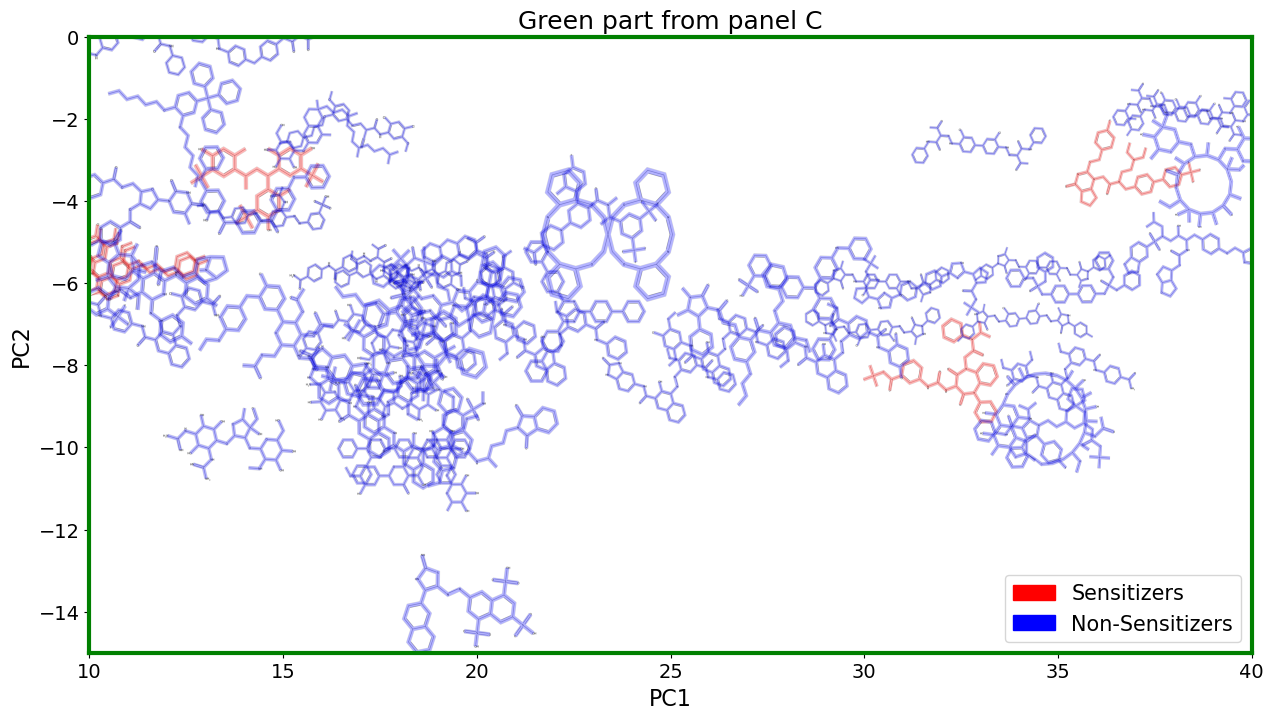

In [6]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
import matplotlib.pyplot as plt
from PIL import Image
import io
xlow=10
xhigh=40
ylow=-15
yhigh=0

# Assuming scatter_data_df is the DataFrame with 'ID', 'SMILES', 'PC1', and 'PC2' columns
filtered_df = scatter_data_df[(scatter_data_df['PC1'] > xlow) & (scatter_data_df['PC1'] < xhigh) &
                              (scatter_data_df['PC2'] > ylow) & (scatter_data_df['PC2'] < yhigh)]

# Using filtered scatter_data_df for red_group and blue_group
red_group = [(smiles, (pc1, pc2)) for smiles, pc1, pc2 in filtered_df[filtered_df['label'] == 1][['SMILES', 'PC1', 'PC2']].values]
blue_group = [(smiles, (pc1, pc2)) for smiles, pc1, pc2 in filtered_df[filtered_df['label'] == 0][['SMILES', 'PC1', 'PC2']].values]

def mol_to_image(mol, color, alpha=0.3):
    num_atoms = mol.GetNumAtoms()
    
    # Increase the base size for the image
    size = 50 + num_atoms * 50
    drawer = rdMolDraw2D.MolDraw2DCairo(size, size-10)
    
    # Set drawing options
    draw_opts = drawer.drawOptions()
    draw_opts.clearBackground = False
    draw_opts.useBWAtomPalette()
    draw_opts.bondLineWidth = 3.0  # Increased bond line width
    draw_opts.atomLabelFontSize = 16  # Adjust this for atom label size if required
    draw_opts.dotsPerAngstrom = 80  # Increase this to get more dots per angstrom, making atoms appear larger
    
    # Color the molecule's bonds with transparency
    transparent_color = (color[0], color[1], color[2], alpha)
    
    bond_colors = {}
    for bond in mol.GetBonds():
        bond_colors[bond.GetIdx()] = transparent_color
    
    # Draw molecule with only bonds highlighted
    drawer.DrawMolecule(mol, highlightAtoms=[], highlightBonds=range(mol.GetNumBonds()), highlightBondColors=bond_colors)
    drawer.FinishDrawing()
    
    # Convert to image and return
    image_data = drawer.GetDrawingText()
    return Image.open(io.BytesIO(image_data))


# Create a scatter plot
fig, ax = plt.subplots(figsize=(15, 8)) 
from rdkit.Chem import Descriptors

def compute_extent(x, y, mol_weight):
    base_extent = 1.8
    # Adjusting factor based on the molecular weight. You can tune this value.
    # The division by 100 is to reduce the weight value to a reasonable factor.
    # Depending on your dataset, you might need to adjust this divisor.
    factor = 0.02 * mol_weight / 100  
    extent_val = base_extent + factor
    return (x - 1*extent_val, x + 1*extent_val, y - extent_val, y + extent_val)

# Plot molecules from the red group with less transparency
for smiles, (x, y) in red_group:
    mol = Chem.MolFromSmiles(smiles)
    mol_weight = Descriptors.MolWt(mol)
    img = mol_to_image(mol, (1, 0, 0))
    ax.imshow(img, aspect='auto', extent=compute_extent(x, y, mol_weight), alpha=1)

# Plot molecules from the blue group with less transparency
for smiles, (x, y) in blue_group:
    mol = Chem.MolFromSmiles(smiles)
    mol_weight = Descriptors.MolWt(mol)
    img = mol_to_image(mol, (0, 0, 1))
    ax.imshow(img, aspect='auto', extent=compute_extent(x, y, mol_weight), alpha=1)


    
# Set axis limits and display the scatter plot
ax.set_xlim(xlow,xhigh)
ax.set_ylim(ylow, yhigh)
# Set the spine colors to orange
ax.spines['bottom'].set_color('green')
ax.spines['left'].set_color('green')
ax.spines['top'].set_color('green')  # Set top boundary color to orange
ax.spines['right'].set_color('green')  # Set right boundary color to orange
for spine in ax.spines.values():
    spine.set_linewidth(3)
# Creating proxy artists for legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='red', edgecolor='red', label='Sensitizers'),
                   Patch(facecolor='blue', edgecolor='blue', label='Non-Sensitizers')]

# Adding the legend to the plot with a larger font size
ax.legend(handles=legend_elements, loc='lower right', fontsize=15)

#ax.xaxis.label.set_color('orange')
#ax.yaxis.label.set_color('orange')
#ax.tick_params(axis='x', colors='orange')
#ax.tick_params(axis='y', colors='orange')

#ax.set_xlabel('X-axis Title', color='orange')  # Replace 'X-axis Title' with your desired title
#ax.set_ylabel('Y-axis Title', color='orange')  # Replace 'Y-axis Title' with your desired title
# Setting the font size for the x and y axis labels
ax.set_xlabel('PC1', fontsize=16)
ax.set_ylabel('PC2', fontsize=16)
ax.set_title('Green part from panel C', fontsize=18)
# Adjust the tick label font size
ax.tick_params(axis='both', which='major', labelsize=14)
plt.savefig("greenpart.pdf", format='pdf', bbox_inches='tight')  # bbox_inches='tight' ensures the saved figure does not cut off any labels or annotations

plt.show()


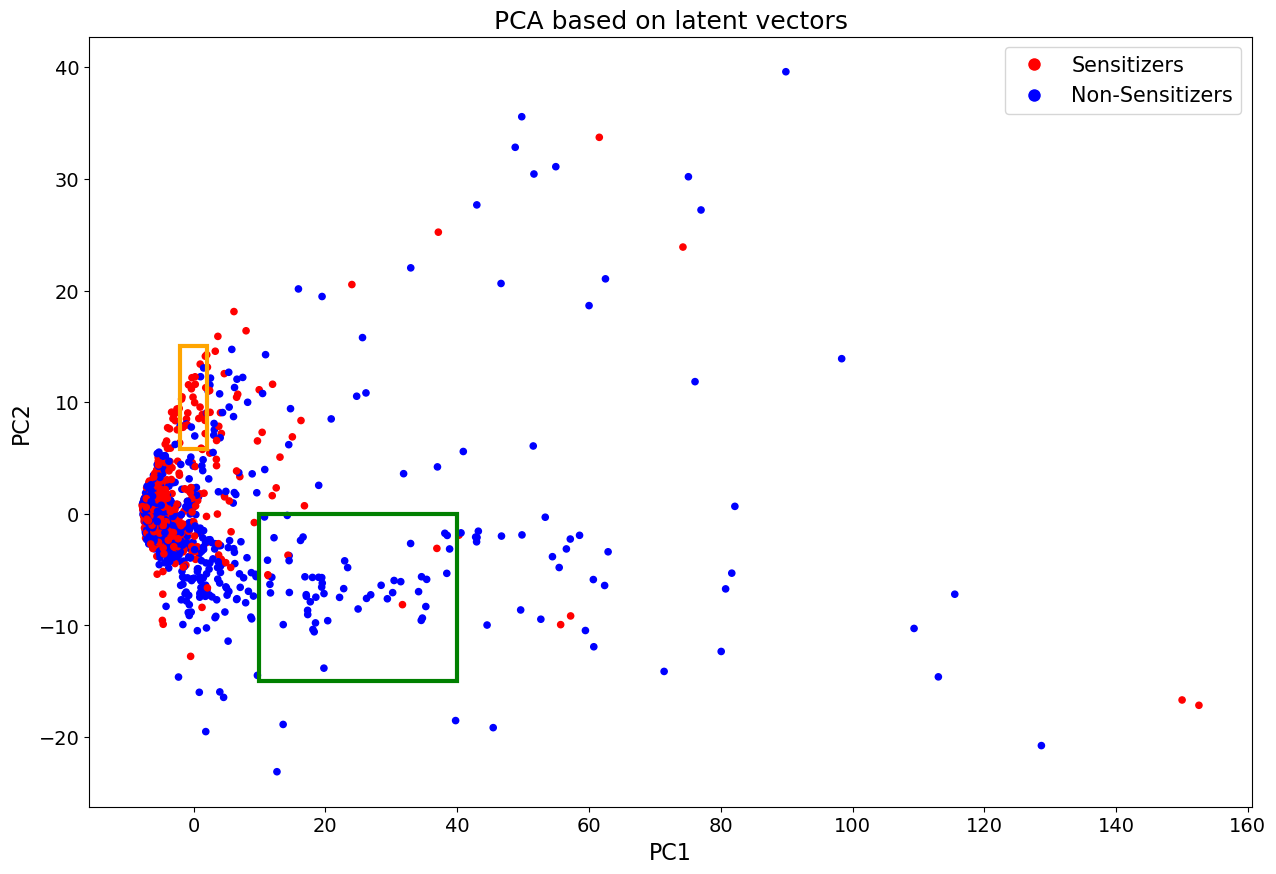

Scatter data saved as scatter_data.csv.


In [7]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# Load data
data = pd.read_csv('alldata_without_outlier.csv')

# Extract the features
features = data.iloc[:, 3:]

# Standardize the features
features_standardized = features  # Consider standardizing the features for PCA for better results.

# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(features_standardized)

# Convert the results to a DataFrame
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Concatenate the ID, SMILES, PC1 and PC2 to form the final DataFrame
scatter_data_df = pd.concat([data['ID'], data['SMILES'], data['label'] ,principal_df], axis=1)

# Save the scatter data as a CSV
scatter_data_df.to_csv('scatter_data.csv', index=False)

# Plotting with a larger figure size
fig, ax = plt.subplots(figsize=(15, 10))  # Setting the figure size to 15x10 inches
colors = {0: 'blue', 1: 'red'}
ax.scatter(final_df['PC1'], final_df['PC2'], c=final_df['label'].map(colors), s=20)




# Making the border of the orange rectangle thicker
rectangle1 = patches.Rectangle((-2, 5.8), 4, 9.2, linewidth=3, edgecolor='orange', facecolor='none')
ax.add_patch(rectangle1)

# Making the border of the green rectangle thicker
rectangle2 = patches.Rectangle((10, -15), 30, 15, linewidth=3, edgecolor='green', facecolor='none')
ax.add_patch(rectangle2)


ax.set_xlabel('PC1', fontsize=16)
ax.set_ylabel('PC2', fontsize=16)
ax.set_title('PCA based on latent vectors', fontsize=18)
# Adjust the tick label font size
ax.tick_params(axis='both', which='major', labelsize=14)


# Create custom legend
# Create custom legend with larger font size
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Sensitizers', markersize=10, markerfacecolor='red'),
                   Line2D([0], [0], marker='o', color='w', label='Non-Sensitizers', markersize=10, markerfacecolor='blue')]

# Add the legend with a larger font size
ax.legend(handles=legend_elements, loc='upper right', fontsize=15)  # Using 'large' for the fontsize, but you can specify a numerical value if needed.

# Save the figure as a PDF
plt.savefig("finalPCA.pdf", format='pdf', bbox_inches='tight')  # bbox_inches='tight' ensures the saved figure does not cut off any labels or annotations

# Show the plot
plt.show()

print("Scatter data saved as scatter_data.csv.")